In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-o9ullo_k
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-o9ullo_k
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-arkf9n5p/pydoe_1e129714e53945ce97786a67f8b2c1a7
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-arkf9n5p/pydoe_1e129714e53945ce97786a67f8b2c1a7
     |████████████████████████████████| 316 kB 4.8 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145057 sha256=c1e9a1dbc61f99370ba2ee0ab901537cdc3ce792a3108a943669485fe7b7b63f
  Stored in directory: /tmp/pip-ephem-wheel-cache-a

In [3]:
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 249 kB 5.0 MB/s 


In [47]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from pyDOE import lhs

from benchmark.bbobbenchmarks import F21, F16

from tqdm.notebook import tqdm, trange

np.random.seed(1111)

dim = 2
lb, ub = -5, 5

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

max_FEs = 50
verbose = False

n_samples = 30000

space = RealSpace([lb, ub]) * dim
samples = space.sample(n_samples)

In [154]:
opt_color, found_color, initial_color = "green", "red", "blue"

def plot(points, colors, ax=plt, outline=False, marker='o', marker_size=30):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker, s=marker_size)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker, s=marker_size)


# plot DoE, optimum, found by the BO, and global optimum on the surface of the function
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s')


# plot initial points provided to the CMA-ES and DoE, found by it, on the surface of the function
def plot_initial_found(func, samples, values, initial, found):
  fig, axs = plt.subplots(1, 2)
  fig.suptitle("Objective function " + func.__class__.__name__, fontsize=8)
  plot(samples, values, ax=axs[0], outline=False) # plot surface
  axs[0].set_title('Initial individual for CMA-ES')
  plot(samples, values, ax=axs[1], outline=False)
  axs[1].set_title('DoE found by CMA-ES')
  plot(initial, ["blue"] * initial.shape[0], ax=axs[0], outline=False)
  plot(found, ["yellow"] * initial.shape[0], ax=axs[1], outline=False)
  plt.show()


# plot DoE, all points used by the BO during training, global optimum, found optimum
def plot_ei_performance(func, samples, values, bo, result, marker_size=30, ax=None, title="BO history"):
  ax.set_title(title, fontsize=8)
  plot(samples, values, ax=ax, outline=False) # plot surface
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=ax, marker='^', marker_size=marker_size*2)
  
  for i in range(1, len(bo.history)):
    for h in bo.history[i]:
      x, y = h
      ax.scatter(x, y, color="magenta", s=marker_size)
      ax.annotate(str(i), h)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s', marker_size=marker_size)

def plot_ei_for_all(func, samples, values, good_bo, good_result, bad_bo, bad_result, marker_size=60):
  fig, axs = plt.subplots(1, 2)
  plot_ei_performance(func, samples, values, good_bo, good_result, marker_size=30, ax=axs[0], title='Best BO history')
  plot_ei_performance(func, samples, values, bad_bo, bad_result, marker_size=30, ax=axs[1], title='Worst BO history')

def plot_ei_for_all_with_removed(func, removed, samples, values, good_bo, good_result, bad_bo, bad_result, marker_size=60, axs=None):
  if axs is None:
    _, axs = plt.subplots(1, 2)
  plot_ei_performance(func, samples, values, good_bo, good_result, marker_size=30, ax=axs[0], title='Best BO history')
  plot_ei_performance(func, samples, values, bad_bo, bad_result, marker_size=30, ax=axs[1], title='Worst BO history')
  r_x, r_y = removed
  axs[0].scatter(r_x, r_y, color="blue", marker='X', s=marker_size*2)
  axs[1].scatter(r_x, r_y, color="blue", marker='X', s=marker_size*2)
  axs[0].annotate(("%0.2f," % r_x) + ("%0.2f" % r_y), removed)
  axs[1].annotate(("%0.2f," % r_x) + ("%0.2f" % r_y), removed)

In [155]:
def plot_removed(result):
  removed = result['removed_point']
  best_try = result['best_bo']
  worst_try = result['worst_bo']
  best_bo, best_xopt, _, _ = best_try
  worst_bo, worst_xopt, _, _ = worst_try
  plot_ei_for_all_with_removed(obj_func, removed, samples, values, best_bo, {"initial_points": doe, "found_x": best_xopt}, worst_bo, {"initial_points": doe, "found_x": worst_xopt}, marker_size=60)

def removed_on_one(results):
  _, axs = plt.subplots(len(results), 2)
  for (ax, result) in zip(axs, results):
    removed = result['removed_point']
    best_try = result['best_bo']
    worst_try = result['worst_bo']
    best_bo, best_xopt, _, _ = best_try
    worst_bo, worst_xopt, _, _ = worst_try
    plot_ei_for_all_with_removed(obj_func, removed, samples, values, best_bo, {"initial_points": doe, "found_x": best_xopt}, worst_bo, {"initial_points": doe, "found_x": worst_xopt}, marker_size=60, axs=ax)

In [160]:
def make_optimizer(obj_func, doe):
    space = RealSpace([lb, ub], random_state=np.random.randint(1, 10000)) * dim
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1
    )

def compute_regret(doe, obj_func, n=3):
  regrets = []
  best_bo, worst_bo = None, None
  for seed in trange(n):
    bo = make_optimizer(obj_func, doe)
    xopt, yopt, _ = bo.run()
    cur_regret = yopt - obj_func.getfopt()
    regrets.append(cur_regret)
    if cur_regret <= min(regrets):
      best_bo = (bo, xopt, yopt, cur_regret)
    if cur_regret >= max(regrets):
      worst_bo = (bo, xopt, yopt, cur_regret)
  return regrets, best_bo, worst_bo

def observe_effect(doe, obj_func, n=3):
  removed_result = []
  doe_size = len(doe)
  for i in trange(0, doe_size):
    reduced_doe = np.concatenate([doe[:i], doe[i + 1:]])
    current_regrets, best_bo, worst_bo = compute_regret(reduced_doe, obj_func, n)
    removed_result.append({'removed_point': doe[i], 'doe': reduced_doe, 'regrets': current_regrets, 'best_bo': best_bo, 'worst_bo': worst_bo})
  return removed_result

# F21

In [74]:
doe_size = 5
obj_func = F21(1)
values = obj_func(samples)
doe = lhs(2, doe_size, random_state=1) * 10 - 5
doe

array([[-2.99977125,  1.69112145],
       [ 3.79353495, -3.55935101],
       [ 1.37252042, -0.81532281],
       [-4.16595599, -2.39533485],
       [-0.70648822,  4.07763347]])

## Use all points of DoE


In [92]:
regret, best_bo_info, worst_bo_info = compute_regret(obj_func, doe, n=30)

  0%|          | 0/30 [00:00<?, ?it/s]

In [93]:
np.mean(regret)

0.8058564654397197

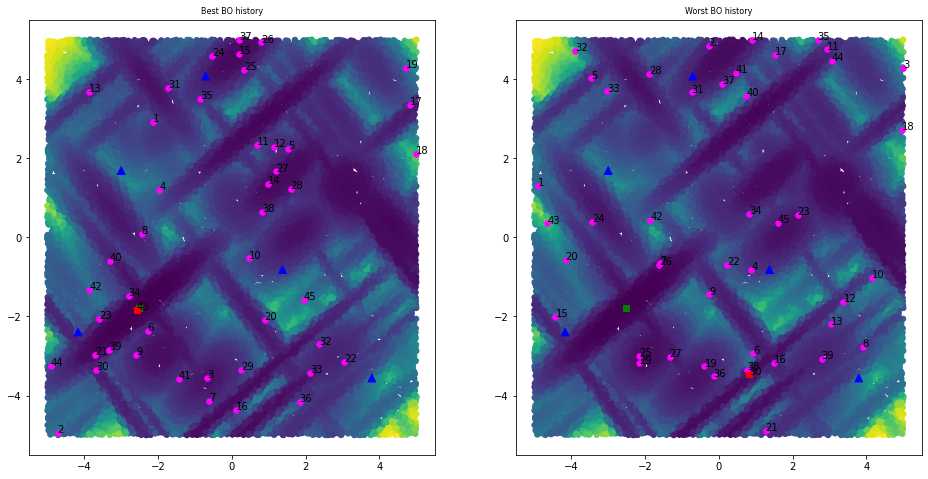

In [94]:
plt.rcParams["figure.figsize"] = (16, 8)

best_bo, best_xopt, _, best_regret = best_bo_info
worst_bo, worst_xopt, _, worst_regret = worst_bo_info

plot_ei_for_all(obj_func, samples, values, best_bo, {"initial_points": doe, "found_x": best_xopt}, worst_bo, {"initial_points": doe, "found_x": worst_xopt}, marker_size=60)

## Remove each point from DoE

In [95]:
removal_result = observe_effect(doe, obj_func, n=30)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

([<matplotlib.axis.XTick at 0x7f9b1b1aeb90>,
 [Text(0, 0, '[-2.99977125  1.69112145]'),
  Text(0, 0, '[ 3.79353495 -3.55935101]'),
  Text(0, 0, '[ 1.37252042 -0.81532281]'),
  Text(0, 0, '[-4.16595599 -2.39533485]'),
  Text(0, 0, '[-0.70648822  4.07763347]')])

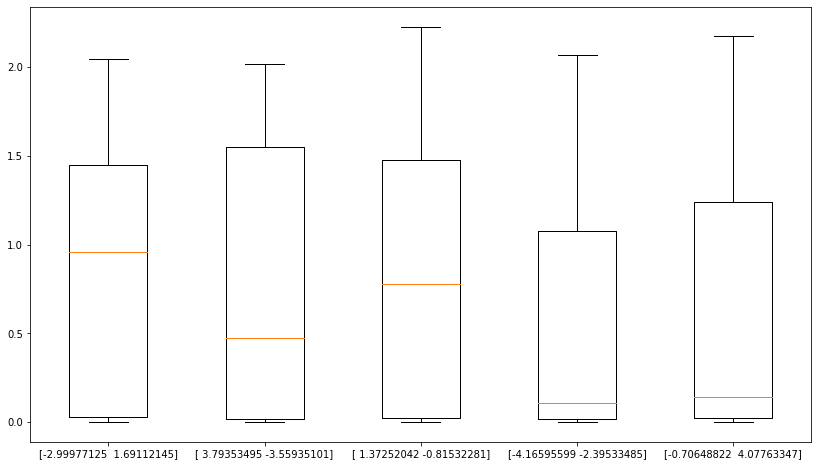

In [96]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [np.concatenate(result['regrets']) for result in removal_result]
plt.boxplot(rs)
plt.xticks(list(range(1, 6)), [result['removed_point'] for result in removal_result])

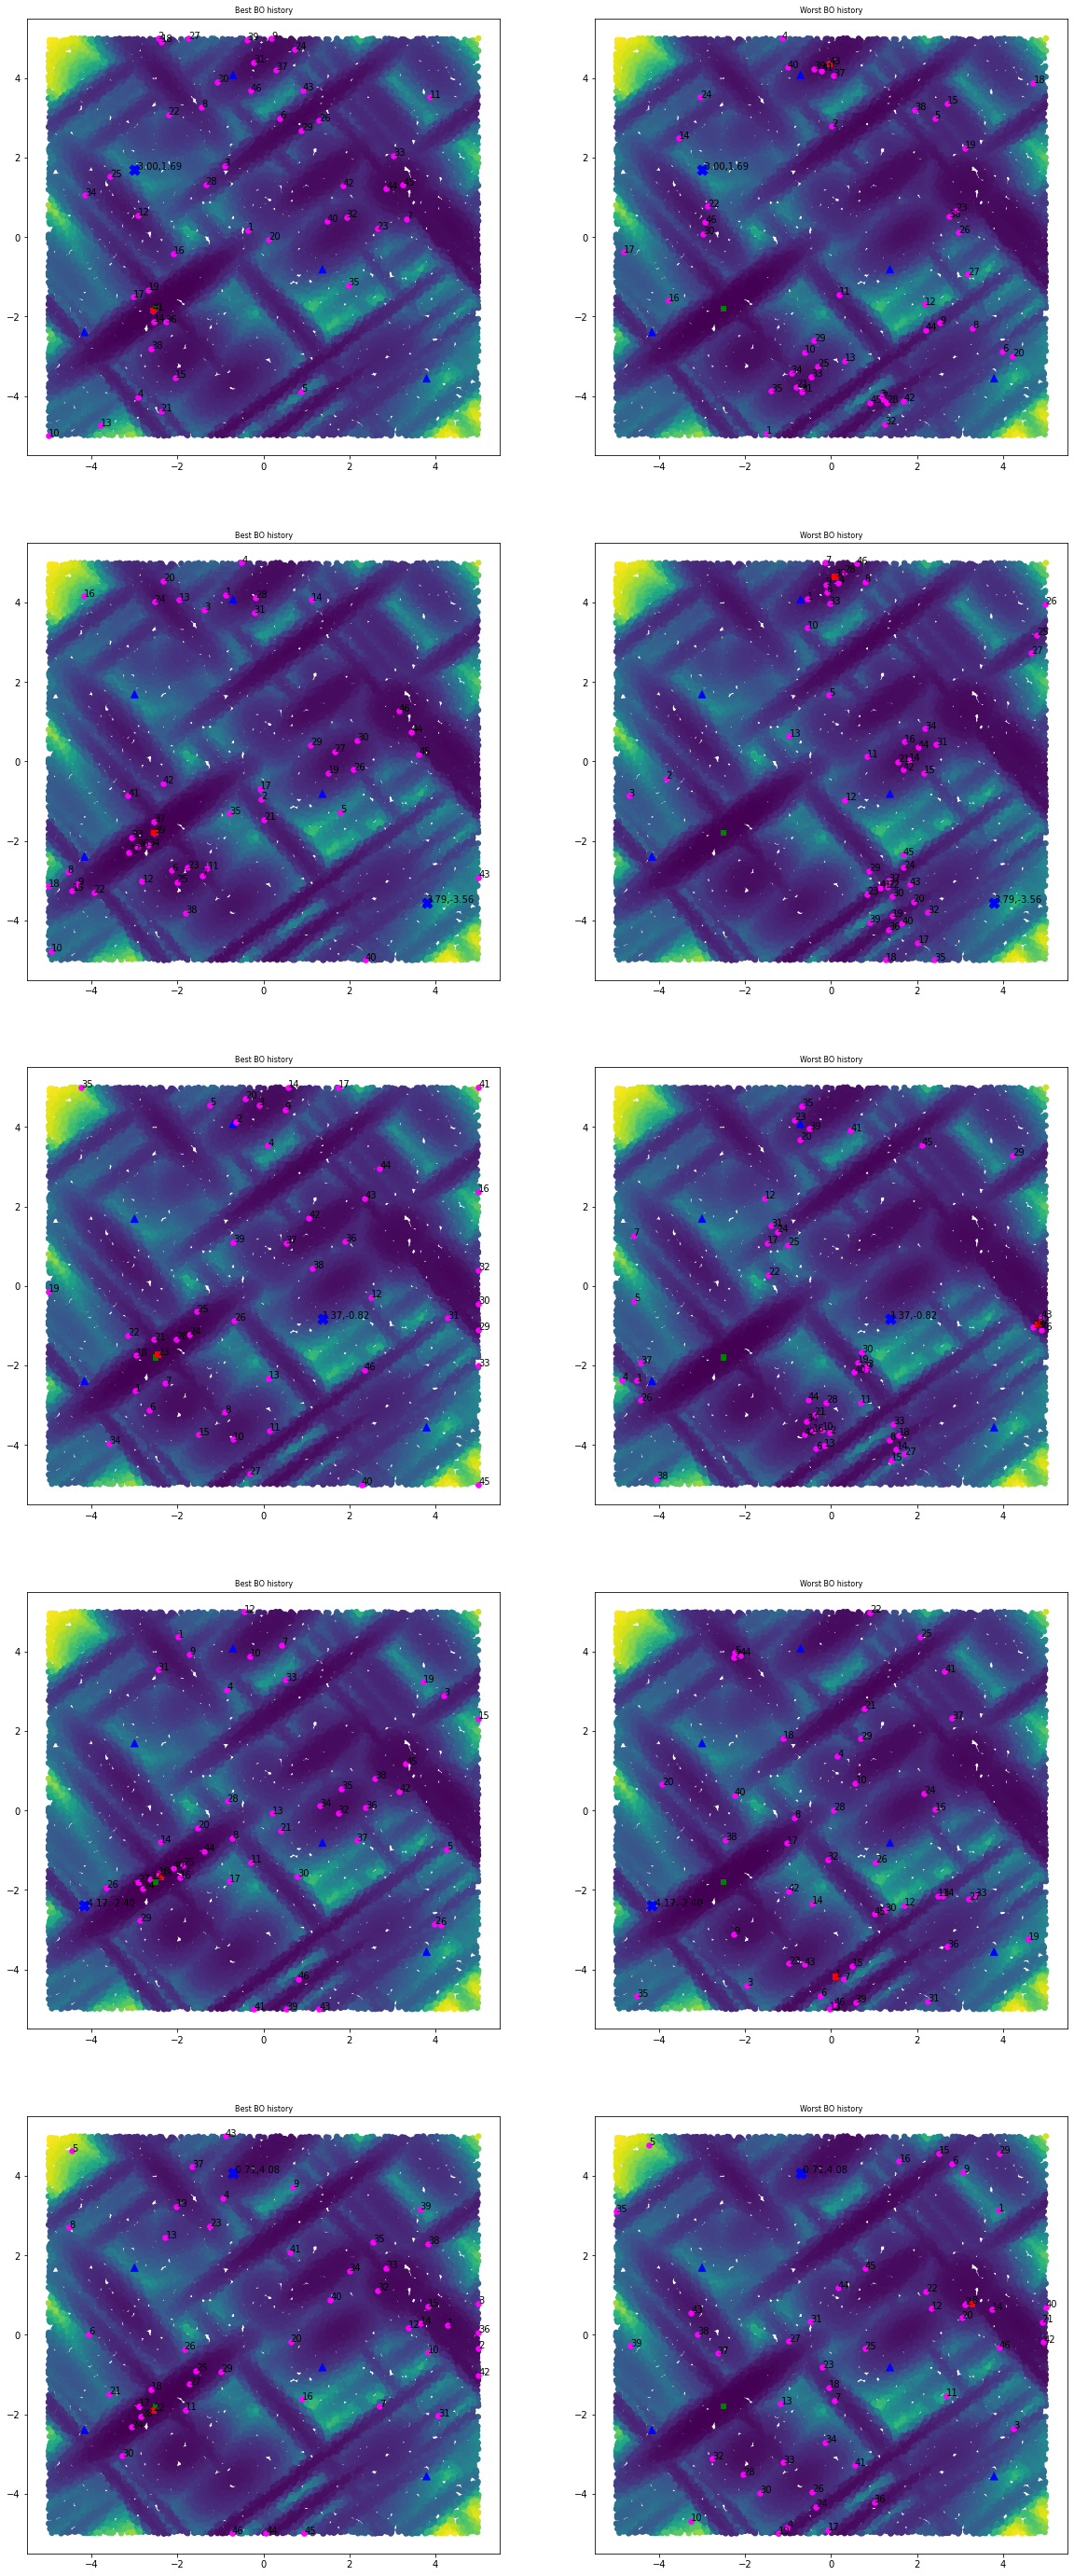

In [157]:
plt.rcParams["figure.figsize"] = (20, doe_size * 10)
removed_on_one(removal_result)

# F16

In [158]:
obj_func = F16(1)
values = obj_func(samples)

## Use all points of DoE

In [161]:
regret, best_bo_info, worst_bo_info = compute_regret(doe, obj_func, n=30)

  0%|          | 0/30 [00:00<?, ?it/s]

In [162]:
np.mean(regret)

2.2559324860533683

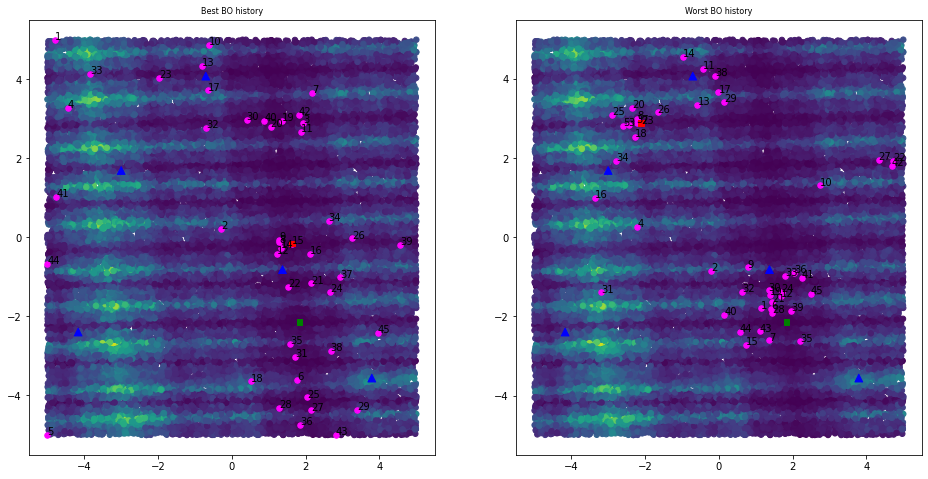

In [163]:
plt.rcParams["figure.figsize"] = (16, 8)

best_bo, best_xopt, _, best_regret = best_bo_info
worst_bo, worst_xopt, _, worst_regret = worst_bo_info

plot_ei_for_all(obj_func, samples, values, best_bo, {"initial_points": doe, "found_x": best_xopt}, worst_bo, {"initial_points": doe, "found_x": worst_xopt}, marker_size=60)

## Remove each point from DoE

In [164]:
removal_result = observe_effect(doe, obj_func, n=30)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

([<matplotlib.axis.XTick at 0x7f9b1a2c0250>,
 [Text(0, 0, '[-2.99977125  1.69112145]'),
  Text(0, 0, '[ 3.79353495 -3.55935101]'),
  Text(0, 0, '[ 1.37252042 -0.81532281]'),
  Text(0, 0, '[-4.16595599 -2.39533485]'),
  Text(0, 0, '[-0.70648822  4.07763347]')])

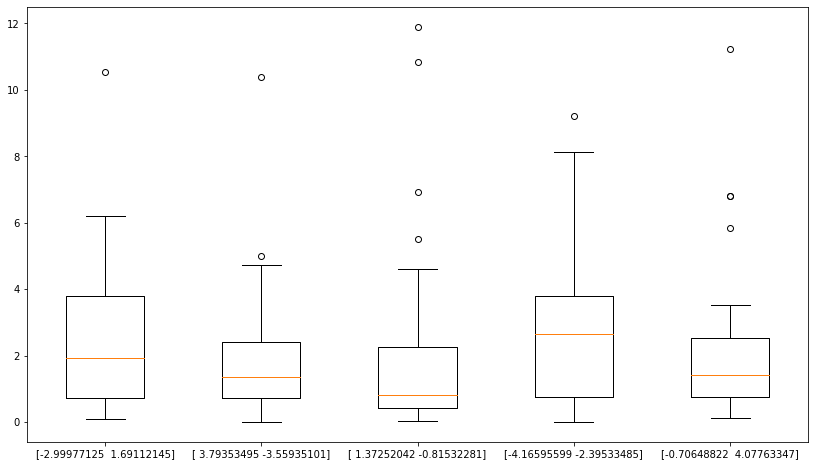

In [165]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [np.concatenate(result['regrets']) for result in removal_result]
plt.boxplot(rs)
plt.xticks(list(range(1, 6)), [result['removed_point'] for result in removal_result])

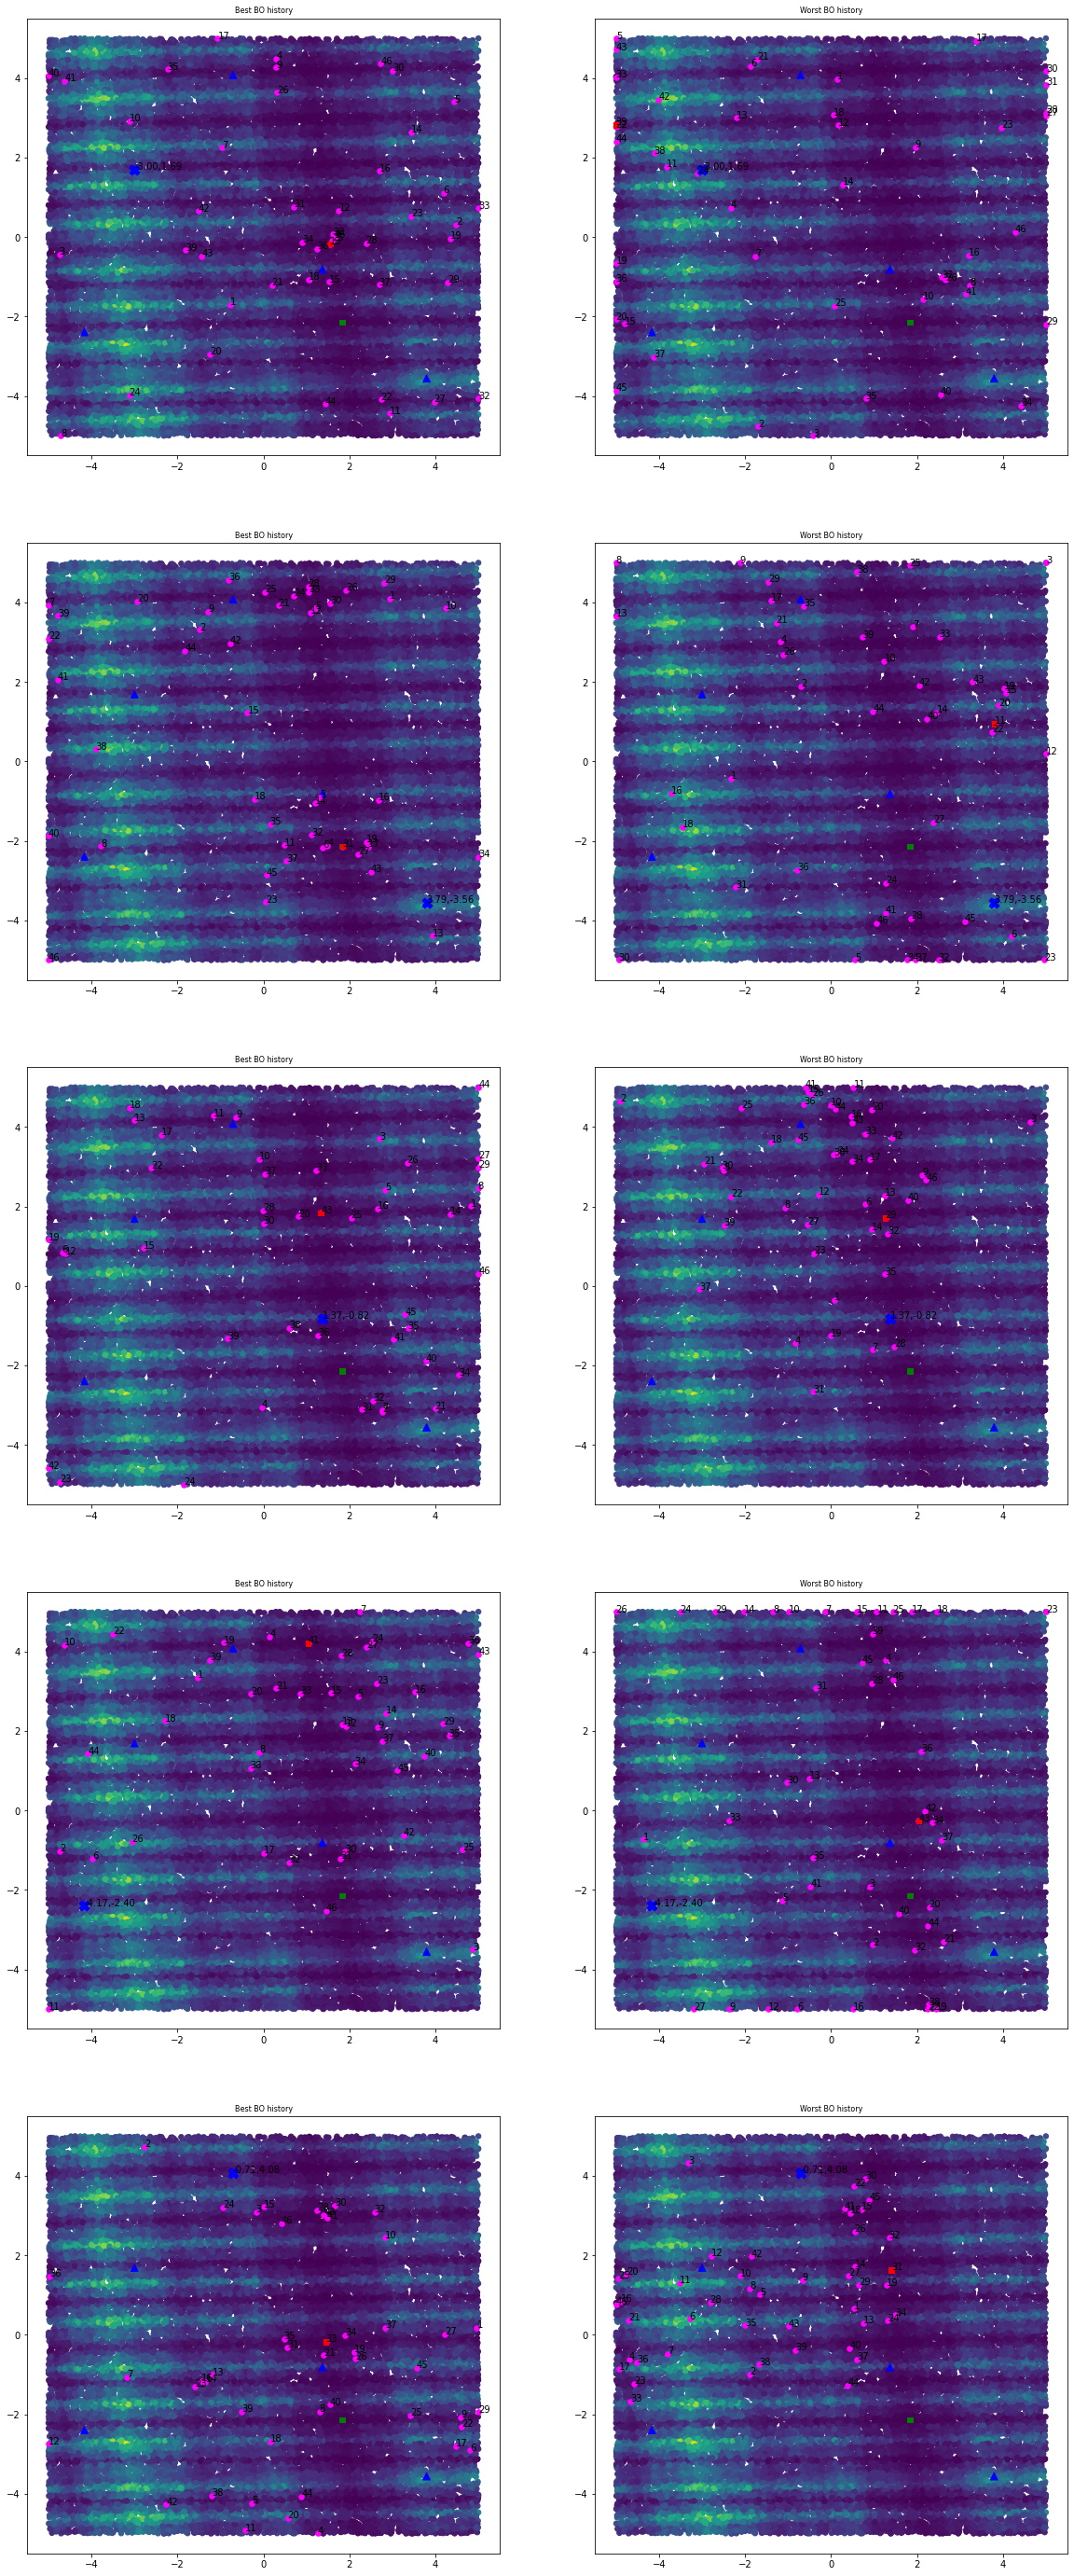

In [166]:
plt.rcParams["figure.figsize"] = (20, doe_size * 10)
removed_on_one(removal_result)